# Bayesian Model for Sleeping and Waking Up

## Problem Description

My Garmin Vivosmart tracks the time I fall asleep and wake up each day. I would like to create a model that returns the probability I am asleep at a given time. That is, given that we know the time, what is the probability I am asleep? This posterior can be expressed as $p(sleep | time)$.

## Approach 

We will assume the transition from waking to sleeping is modeled as a logistic function. To find the parameters of the logistic function, we can use Markov Chain Monte Carlo sampling of the parameters informed by the data. We will assume the priors for the parameters are normal distributions and the algorithm will attempt to maximize the likelihood of the parameters given the data. The return values from the MCMC will be the randomly drawn samples from the posterior for the parameters. We can then create the most likely logistic function using the average values of the samples. 

The end outcome will be two models, one for sleep and one for waking up, which will return the probability of being asleep at a given time. We could simply use a frequentist approach and say that the probability of being asleep is equal to the observed probability at that time, but the measured values are not the true values. Using Bayesian Inference will allow us to find the probability of being asleep which reflects the uncertainty around modeling real-world data. We will make extensive use of the [PyMC3 library](https://github.com/pymc-devs/pymc3) in this report. 

In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.pylabtools import figsize
import matplotlib

import json
s = json.load(open('style/bmh_matplotlibrc.json'))
matplotlib.rcParams.update(s)

matplotlib.rcParams['figure.figsize'] = (10, 3)
matplotlib.rcParams['font.size'] = 14

# Parameter for changing the number of sampling steps
N_SAMPLES = 5000

# Wake Sleep Data

The Wake and Sleep data contains about two months of observations. The Garmin is definitely not 100% accurate, because often it will think I'm sleeping if I turn off notifications and read in bed. Sometimes we have to deal with imperfect data, and because the truthful observations outweight the false, they should have a larger impact on the model. 

In [3]:
data = pd.read_csv('data/sleep_wake.csv')
data.set_index('Date', inplace=True, drop=True)
data.index=data.index.to_datetime(dayfirst=False)
data = data.ix[:, 0:2]

In [4]:
data['Sleep_time'] = [entry[0] + pd.DateOffset(minutes=entry[1], hours=22) for entry in zip(data.index, data['Sleep'])]
data['Wake_time'] = [entry[0] + pd.DateOffset(minutes=entry[1], hours=6) for entry in zip(data.index, data['Wake'])]
data.head()

,Sleep,Wake,Sleep_time,Wake_time
2017-12-01,16,1,2017-12-01 22:16:00,2017-12-01 06:01:00
2017-12-02,19,-10,2017-12-02 22:19:00,2017-12-02 05:50:00
2017-12-03,-45,0,2017-12-03 21:15:00,2017-12-03 06:00:00
2017-12-04,8,1,2017-12-04 22:08:00,2017-12-04 06:01:00
2017-12-05,-23,-16,2017-12-05 21:37:00,2017-12-05 05:44:00


## Data Structuring

In [5]:
# Create a separate sleep dataframe
sleep_index = pd.date_range(start=min(data.index), end=max(data.index), freq='60S')
sleep_index = [time for time in sleep_index if (time.hour >= 21) & (time.hour <= 23)]
sleep_data = pd.DataFrame(0, columns=['indicator'], index=sleep_index)

# Set an index with an indicator for times when I am asleep
# Indicator = 1 when I am asleep, else 0
for time in sleep_data.index:
    for sleep_time in data['Sleep_time']:
        if time == sleep_time:
            selected_date = time.date()
            date_subset = [date for date in sleep_data.index if date.date() == selected_date]
            asleep_times = [time for time in date_subset if time.time() >= sleep_time.time()]
            sleep_data.ix[asleep_times, 'indicator'] = 1
            
# Create a separate wake dataframe
wake_index=pd.date_range(start=min(data.index), end=max(data.index), freq='60S')
wake_index = [time for time in wake_index if (time.hour <= 7) & (time.hour >= 5)]
wake_data = pd.DataFrame(1, columns=['indicator'], index=wake_index)

# Set an index with indicator for times when I am asleep
# Indicator = 1 when I am asleep, else 0
for time in wake_data.index:
    for wake_time in data['Wake_time']:
        if time == wake_time:
            selected_date = time.date()
            date_subset = [date for date in wake_data.index if date.date() == selected_date]
            wake_times = [time for time in date_subset if time.time() >= wake_time.time()]
            wake_data.ix[wake_times, 'indicator'] = 0
    
# Time offset column 
# For sleep, offset from 10:00 PM
sleep_data['time_offset'] = [int((time.hour * 60 + time.minute) - (22 * 60)) for time in sleep_data.index]
# For wake, offset from 6:00 AM
wake_data['time_offset'] = [int((time.hour * 60 + time.minute) - (6 * 60)) for time in wake_data.index]

In [53]:
# Labels for plotting
sleep_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

## Visualizations of Data

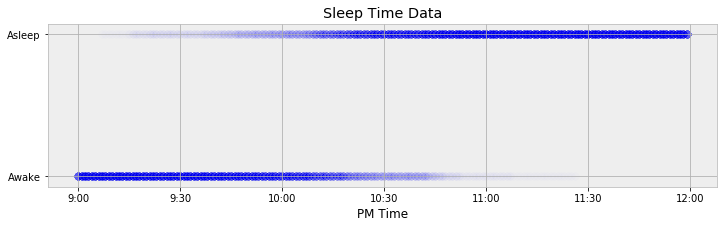

In [163]:
figsize(12, 3)

# Sleep data
plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('PM Time'); plt.title('Sleep Time Data')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

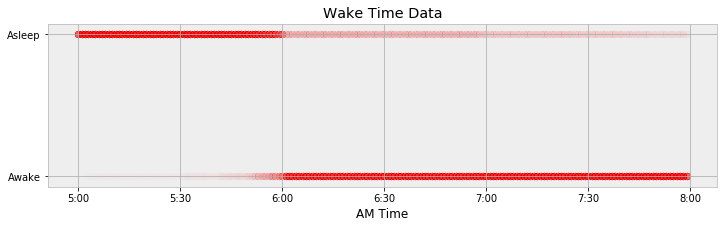

In [164]:
# Wake data
plt.scatter(wake_data['time_offset'], wake_data['indicator'], s= 50, alpha = 0.01, 
            facecolor='r', edgecolors =  'r');
plt.yticks([0, 1], ['Awake', 'Asleep']); plt.xlabel('AM Time'); plt.title('Wake Time Data')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

# Modeling Transition as a Logistic Function

We want to find some model that expressions the transition from awake to asleep (or vice versa) as a function of time. The function must take values between 0 and 1 and increase to 1 as the time past 10 increases. There are a number of options, but here I will choose the logistic function. A logistic function is of the form 

$$p(t) = \frac{1}{ 1 + e^{\;\beta t } }$$

The variable we do not know is $\beta$ which controls the shape of the distribution. The following graphs show the logistic function with different values of $\beta$

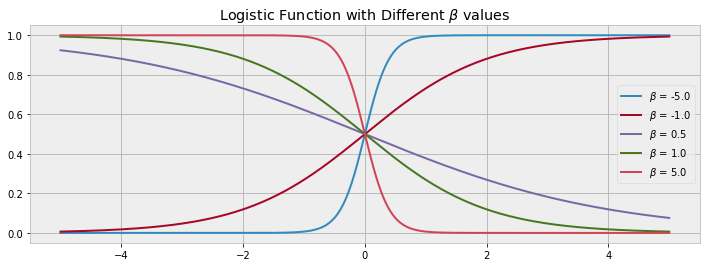

In [12]:
figsize(12, 4)

# Logistic function with only beta
def logistic(x, beta):
    return 1. / (1. + np.exp(beta * x))

# Plot examples with different betas 
x = np.linspace(-5, 5, 1000)
for beta in [-5, -1, 0.5, 1, 5]:
    plt.plot(x, logistic(x, beta), label = r"$\beta$ = %.1f" % beta)

plt.legend();
plt.title(r'Logistic Function with Different $\beta$ values');

There is one problem with the basic logistic function: the transition might not occur at 0 (which is 10:00 pm for sleeping and 6:00 am for waking). We can add an offset, called a bias, to adjust the location of the logistic function. We will call this parameter $\alpha$ and will also learn this from the data. The logistic function is now:

$$p(t) = \frac{1}{ 1 + e^{\;\beta t + \alpha} }$$

Different values of alpha are shown below.

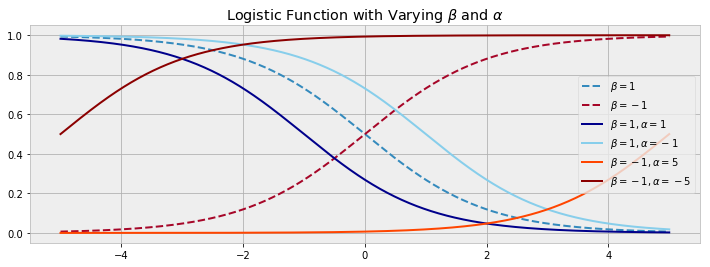

In [13]:
# Logistic function with both beta and alpha
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-5, 5, 1000)

plt.plot(x, logistic(x, beta=1), label=r"$\beta = 1$", ls="--", lw=2)
plt.plot(x, logistic(x, beta=-1), label=r"$\beta = -1$", ls="--", lw=2)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$", color="darkblue")
plt.plot(x, logistic(x, 1, -1), label=r"$\beta = 1, \alpha = -1$",color="skyblue")
plt.plot(x, logistic(x, -1, 5), label=r"$\beta = -1, \alpha = 5$", color="orangered")
plt.plot(x, logistic(x, -1, -5), label=r"$\beta = -1, \alpha = -5$", color="darkred")
plt.legend();
plt.title(r'Logistic Function with Varying $\beta$ and $\alpha$');

$\beta$ shifts the direction and steepness of the curve, while $\alpha$ changes the location. We will need to use the data to find the most likely value of these parameters for both sleeping and waking. 

# Assume Priors are Normally Distributed

We have no idea what the prior distributions for the model parameters are ahead of time. Therefore, we can model them as if they came from a normal distribution. The normal distribution is entirely defined by the mean, $\mu$, and the precision, $\tau$. The precision is the reciprocal of the standard deviation, $\sigma$. The mean defines the location of the distribution and the precision is the spread. A larger value of $\tau$ indicates the data is less spread out and hence the variation is smaller. The mean can be either positive or negative, but the precision will always be positive. A normal distribution is represented as:

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x - \mu)^2 \right) $$

Probability density functions for three normal distributions are shown below.

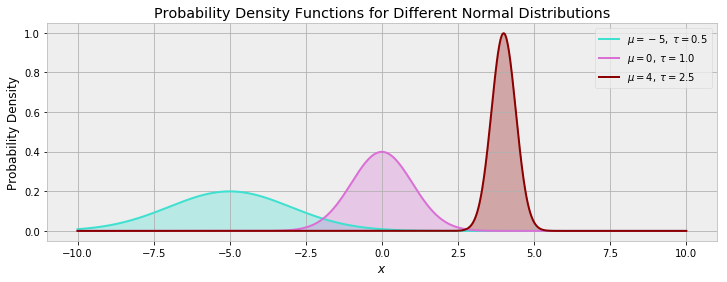

In [14]:
import scipy.stats as stats

# Set up the plotting parameters
nor = stats.norm 
x= np.linspace(-10, 10, 1000)
mu = (-5, 0, 4)
tau = (0.5, 1, 2.5)
colors = ("turquoise", "orchid", "darkred")

# Plot 3 pdfs for different normal distributions
params = zip(mu, tau, colors)
for param in params:
    y = nor.pdf(x, loc = param[0], scale = 1/param[1])
    plt.plot(x, y, label="$\mu = %d,\;\\tau = %.1f$" % (param[0], param[1]), color = param[2])
    plt.fill_between(x, y, color = param[2], alpha = 0.3)
    
plt.legend();
plt.xlabel("$x$")
plt.ylabel("Probability Density")
plt.title("Probability Density Functions for Different Normal Distributions");

The expected value of a normal distribution is the mean. 
$$ E[ X | \mu, \tau] = \mu$$ 

with the variance equal to:

$$ Var[ X | \mu, \tau) = \frac{1}{\tau}$$

We have no prior assumptions about the value for either $\mu$ or $\tau$ for the two parameters in our logistic function $\alpha$ and $\beta$. When we initialize the model, we can use $\mu = 0$ and a relatively large variance such as $\tau = 0.05$

# Complete Model

We have all the pieces and it is time to put them together. The logistic function describes the transition from awake to asleep, but we do not konw the parameters. The aim is to find the parameters of the logistic function which maximize the likelihood of the observed data. The parameters are assumed to come from a normal distribution defined by a mean and a variance. 

## Bernoulli Variable

A bernoulli variable is a discrete random variable that is either 0 or 1. In our example, we can model asleep or awake as a Bernoulli variable where awake is 0 and asleep is 1. The variable is a function of the time, so we need a model that outputs a probability for being asleep given the time. The final model looks like

$$ \text{Sleep Probability, $S_i$} \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$

where $p(t_i)$ is the logistic function for each value of time.

$$ p(t_i) = \frac{1}{1 + e^{(\beta t_i + \alpha)}}$$

with the unknown parameters $\beta$ and $\alpha$ assumed to come from a normal distribution.

## Sleep Model

First we will create a model for the sleep data. We use a Markov Chain Monte Carlo simluation to draw thousands of samples from the posterior distribution of $\alpha$ and $\beta$

### PyMC3 

We are using a powerful Bayesian Inference library in Python called PyMC3. This library has features for running Markov Chain Monte Carlo and other inference algorithms. This report does not detail PyMC3, but a great book for getting started is _Probabilistic Programming and Bayesian Methods for Hackers_ by Cameron Davidson-Pilon which is available for free on [GitHub](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

In [15]:
# Sort the values by time offset
sleep_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(sleep_data.loc[:, 'time_offset'])

# Observations are the indicator
sleep_obs = np.array(sleep_data.loc[:, 'indicator'])

In [16]:
import pymc3 as pm
import theano.tensor as tt
import scipy

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [17]:
with pm.Model() as sleep_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.05, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.05, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed data
    observed = pm.Bernoulli('obs', p, observed=sleep_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    sleep_trace = pm.sample(N_SAMPLES, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.


The trace contains all of the samples drawn from the posterior for alpha and beta. We can graph these samples to explore what they look like. In Markov Chain Monte Carlo, it is common practice to discard a portion of the samples usually about 50%, which are known as the burn-in samples. The algorithm does not immediately converge and the later samples are generally more representative of the data. 

## Visualize Posteriors for Alpha and Beta

The values returned by the MCMC are samples drawn from the posterior and hence represent an approximation of the posterior distribution. The best way to look at these values is to depict them as histograms.  

In [18]:
# Extract the alpha and beta samples
# Currently using all, including the burn-in period
alpha_samples = sleep_trace["alpha"][:, None]
beta_samples = sleep_trace["beta"][:, None]

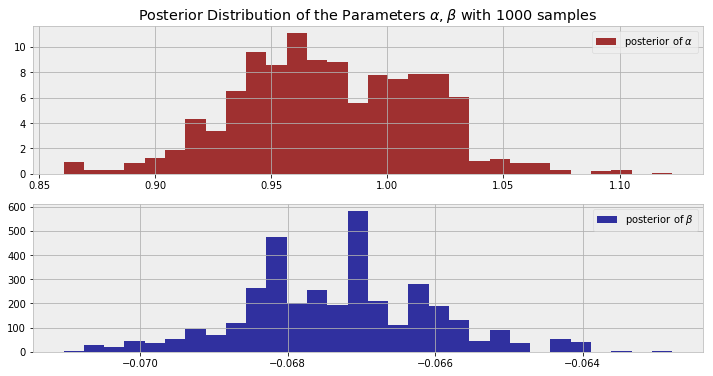

In [38]:
figsize(12, 6)

plt.subplot(211)
plt.title(r"Posterior Distribution of the Parameters $\alpha, \beta$ with %d samples" % N_SAMPLES)
plt.hist(alpha_samples, histtype='stepfilled', color = 'darkred', 
         bins=30, alpha=0.8, label=r"posterior of $\alpha$", normed=True);
plt.legend()

plt.subplot(212)

plt.hist(beta_samples, histtype='stepfilled', color = 'darkblue',
         bins=30, alpha=0.8, label=r"posterior of $\beta$", normed=True)
plt.legend();

If the $\beta$ values were centered around 0 that would indicate the time has no effect on the probability of being asleep. The $\alpha$ values also are not at 0, indicating that there is an offset from 10:00 pm in terms of being asleep. 

The spread of the data gives us a measure of uncertainty about the data. A larger spread indicates more uncertainty. As there is some overlap between awake and asleep, the uncertainty is expected to be large. 

To show the results of the model, we can create the logistic function with the most likely values of $\alpha$ and $\beta$ which we can take to be the mean of the posterior samples. 

In [72]:
# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15, 1e5)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
sleep_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

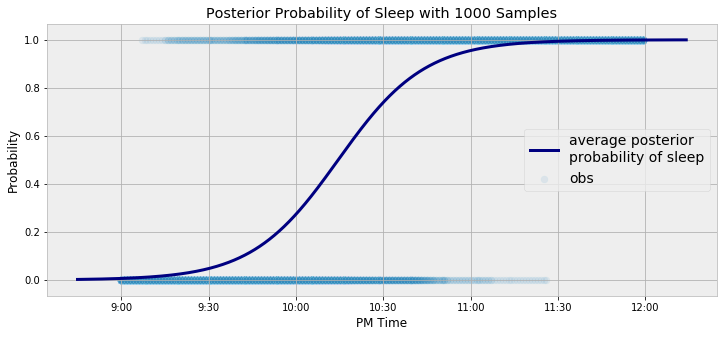

In [73]:
figsize(12, 5)

plt.plot(time_est, sleep_est, color = 'navy', 
         lw=3, label="average posterior \nprobability of sleep")
plt.scatter(time, sleep_obs, edgecolor = 'skyblue', s=50, alpha=0.1, label='obs')
plt.title('Posterior Probability of Sleep with %d Samples' % N_SAMPLES);
plt.legend(prop={'size':14})
plt.ylabel('Probability')
plt.xlabel('PM Time');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

In [ ]:
import matplotlib as mpl

colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = sleep_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('Probability of Sleep as Function of Time')
plt.xlabel('PM Time');
plt.ylabel('Probability');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

This is helpful, and now we can pass in any time and receive an estimated probability that I am asleep. The time is passed in as an offset from 10:00 pm.

In [74]:
print('10:00 PM probability of being asleep: {:.2f}%.'.format(100 * logistic(0, beta_est, alpha_est)))
print('9:30  PM probability of being asleep: {:.2f}%.'.format(100 * logistic(-30, beta_est, alpha_est)))
print('10:30 PM probability of being asleep: {:.2f}%.'.format(100 * logistic(30, beta_est, alpha_est)))

10:00 PM probability of being asleep: 27.37%.
9:30  PM probability of being asleep: 4.76%.
10:30 PM probability of being asleep: 73.95%.


### Confidence Interval

There are many other diagnostics of the model that we can perform. For example, we know there is a considerable amount of uncertainty in our parameter estimates. A better way to show the graph therefore would be to include the 95% confidence interval at each time. 

In [75]:
from scipy.stats.mstats import mquantiles

sleep_all_est = logistic(time_est.T, beta_samples, alpha_samples)
quantiles = mquantiles(sleep_all_est, [0.025, 0.975], axis=0)

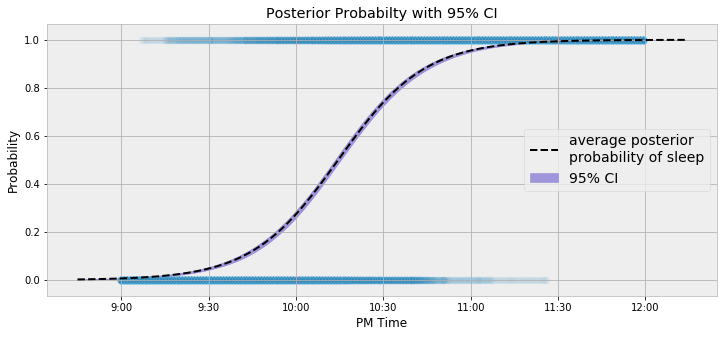

In [83]:
plt.fill_between(time_est[:, 0], *quantiles, alpha=0.6, color='slateblue', label = '95% CI')
plt.plot(time_est, sleep_est, lw=2, ls='--', color='black', label="average posterior \nprobability of sleep")
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);
plt.scatter(time, sleep_obs, edgecolor = 'skyblue', s=50, alpha=0.1);
plt.legend(prop={'size':14})
plt.xlabel('PM Time'); plt.ylabel('Probability'); plt.title('Posterior Probabilty with 95% CI');

## Posterior Probability for Specific Time

We can plot the posterior distribution for time where each estimate is taken using all the samples from the Markov Chain Monte Carlo. This gives us a look at the uncertainty in the model. Each estimate is made using different values from the sampling.

In [97]:
def sleep_posterior(time_offset):
    figsize(12, 4)
    prob = logistic(time_offset, beta_samples, alpha_samples
    plt.hist(prob, bins=100, histtype='step', lw=2)
    plt.title('Posterior Distribution for Sleep Gven time offset = %d' % time_offset)
    plt.xlabel('Probability of Sleep'); plt.ylabel('Samples')
    plt.show();

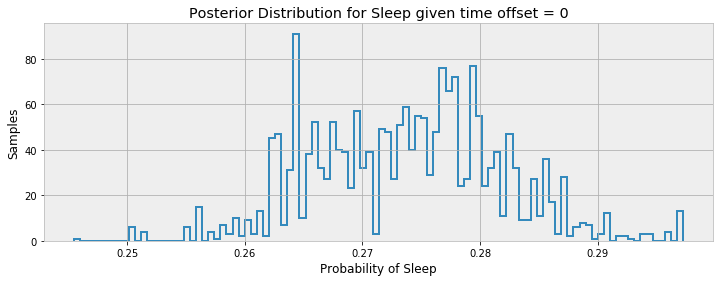

In [98]:
sleep_posterior(0)

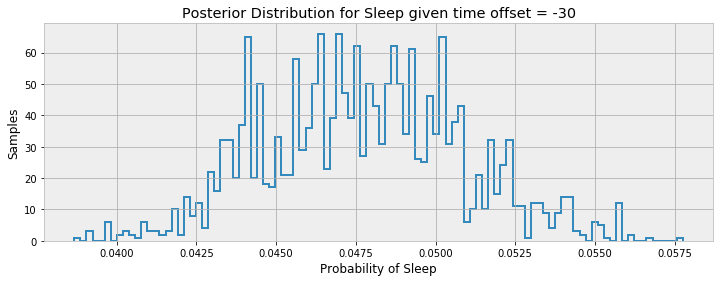

In [99]:
sleep_posterior(-30)

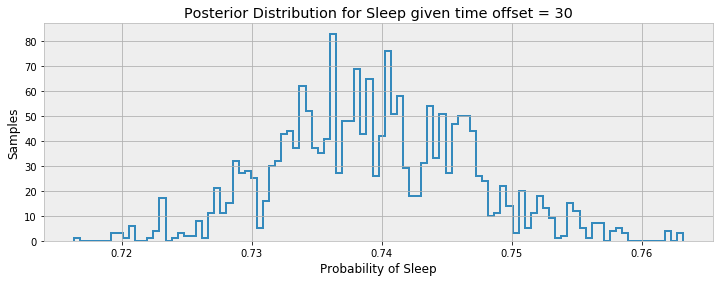

In [100]:
sleep_posterior(30)

# Convergence in Markov Chain Monte Carlo

How can we know if the model converged? We can look at the trace, or the path of the values over sampling. Another option is to look at the auto-correlation of the samples. In Markov Chain modeling, the samples are correlated with themselves because the next value depends on the current state (or the current state and past states based on the order). Initially, the algorithm tends to wander about the search space and will have a high auto-correlation. As the algorithm converges, the samples will settle down around a value and one measure of convergence is a low auto-correlation. 

## Trace Plots

We can start off making traces of $\alpha$ and $\beta$ parameters as the algorithm progresses.
There is a burn in period, and usually this is removed from the samples because it is not indicative of the final converged values. 

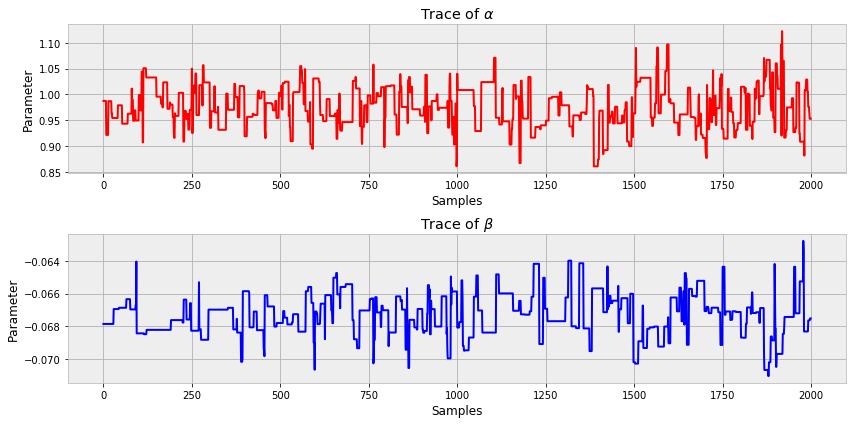

In [109]:
figsize(12, 6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_samples)
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)


There is a large amount of variability over the course of the sampling. The algorithm should probably be run for more iterations. There is not a noticeable burn-in period, but that may be because the MCMC was not run for long enough to have a different burn-in period. 

The last part of diagnosing the model with look at the autocorrelation. The autocorrelation should decrease as the algorithm runs. 

In [145]:
# Function to calculate autocorrelation in a series of data points
def autocorr(x):
    result = np.correlate(x, x, mode = 'full')
    # Normalization
    result = result / np.max(result)
    return result[result.size // 2:]

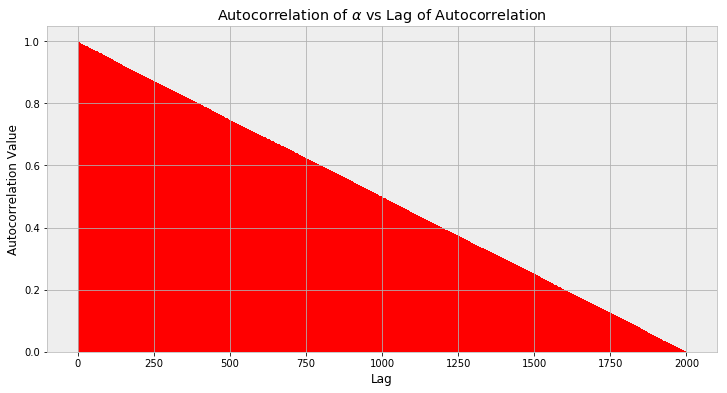

In [150]:
x = list(range(len(alpha_samples[:, 0])))
plt.bar(x, autocorr(alpha_samples[:,0]), width=1, alpha = 1,
        label=r'$\alpha$',color='r')
plt.title(r'Autocorrelation of $\alpha$ vs Lag of Autocorrelation')
plt.xlabel('Lag'); plt.ylabel('Autocorrelation Value');

plt.bar(x, autocorr(beta_samples[:, 0]), width=1, alpha = 1,
        label=r'$\beta$', color='b')
plt.title(r'Autocorrelation of $\beta$ vs Lag of Autocorrelation')
plt.xlabel('Lag'); plt.ylabel('Autocorrelation Value');

# Wake Model

We can repeat the same procedure with the wake data. The process is exactly the same we are just using different data. 

In [152]:
# Sort the values by time offset
wake_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(wake_data.loc[:, 'time_offset'])

# Observations are the indicator
wake_obs = np.array(sleep_data.loc[:, 'indicator'])

with pm.Model() as wake_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.05, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.05, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed data
    observed = pm.Bernoulli('obs', p, observed=wake_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    wake_trace = pm.sample(N_SAMPLES, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
The estimated number of effective samples is smaller than 200 for some parameters.


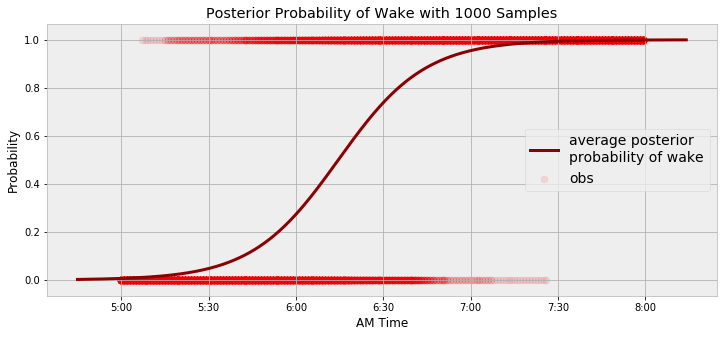

In [155]:
# Extract the alpha and beta samples
# Currently using all, including the burn-in period
alpha_samples = wake_trace["alpha"][:, None]
beta_samples = wake_trace["beta"][:, None]

# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15, 1e5)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
wake_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

figsize(12, 5)

plt.plot(time_est, wake_est, color = 'darkred', 
         lw=3, label="average posterior \nprobability of wake")
plt.scatter(time, sleep_obs, edgecolor = 'r', facecolor = 'r', 
            s=50, alpha=0.05, label='obs')
plt.title('Posterior Probability of Wake with %d Samples' % N_SAMPLES);
plt.legend(prop={'size':14})
plt.ylabel('Probability')
plt.xlabel('AM Time');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

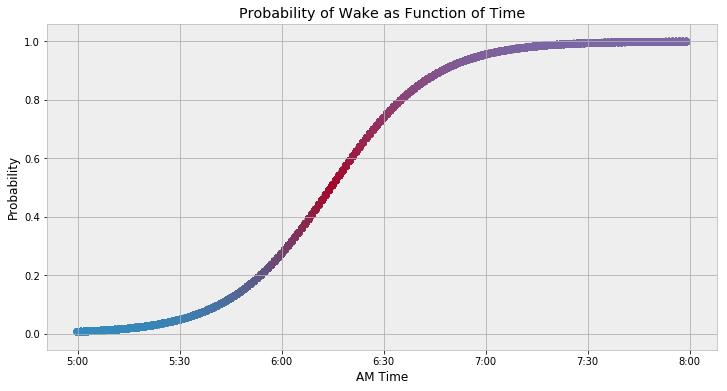

In [156]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = wake_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('Probability of Wake as Function of Time')
plt.xlabel('AM Time');
plt.ylabel('Probability');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

## Investigate the Model

In [159]:
print('Probability of Wake at 5:30 AM: {:.2f}%.'.format(100 * logistic(-30, beta=beta_est, alpha=alpha_est)))
print('Probability of Wake at 6:00 AM: {:.2f}%.'.format(100 * logistic(0, beta=beta_est, alpha=alpha_est)))
print('Probability of Wake at 6:30 AM: {:.2f}%.'.format(100 * logistic(30, beta=beta_est, alpha=alpha_est)))

Probability of Wake at 5:30 AM: 4.78%.
Probability of Wake at 6:00 AM: 27.36%.
Probability of Wake at 6:30 AM: 73.86%.


## Confidence Intervals (95%)

In [160]:
wake_all_est = logistic(time_est.T, beta_samples, alpha_samples)
quantiles = mquantiles(wake_all_est, [0.025, 0.975], axis=0)

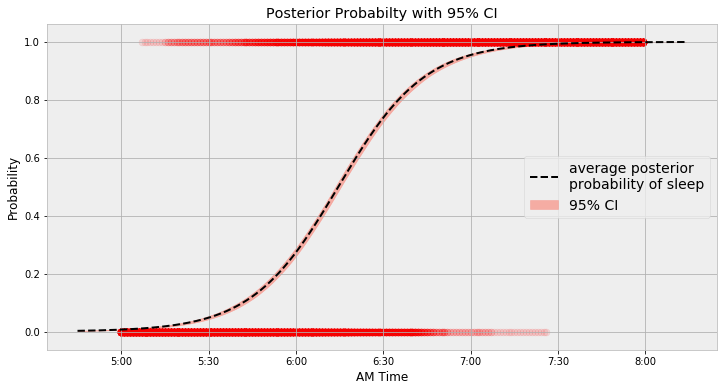

In [161]:
plt.fill_between(time_est[:, 0], *quantiles, alpha=0.6, color='salmon', label = '95% CI')
plt.plot(time_est, wake_est, lw=2, ls='--', color='black', label="average posterior \nprobability of sleep")
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);
plt.scatter(time, sleep_obs, edgecolor = 'red', facecolor = 'red', s=50, alpha=0.1);
plt.legend(prop={'size':14})
plt.xlabel('AM Time'); plt.ylabel('Probability'); plt.title('Posterior Probabilty with 95% CI');

# Length of Sleep 

We can also form a model to estimate the most likely length of time I am asleep. 